Normalizing Flows is a rich family of distributions. They were discribed in [arXiv:1505.05770v6](https://arxiv.org/abs/1505.05770) and their experiments prooved the importance of studying them further. Some extensions like [arXiv:1611.09630v4](https://arxiv.org/abs/1611.09630) made computationally tractable (partially)full rank gaussians approximations for high dimensional spaces. In this notebook I'll show some tips and tricks for normalizing flows in PyMC3

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import numpy as np
from theano import theano, tensor as tt
pm.set_tt_rng(44)
np.random.seed(44)

## Theory

Normalizing Flow is a series of invertible transformations on initial distribution. 

$$z_K = f_K \circ \dots \circ f_2 \circ f_1(z_0) $$

In that case we can compute tractable density for the flow.

$$\ln q_K(z_K) = \ln q_0(z_0) - \sum_{k=1}^{K}\ln \left|\frac{\partial f_k}{\partial z_{k-1}}\right|$$


Every $f_k$ here is a parametric function with defined determinant. We can choose every step here. For example the simplest flow is an affine transform:

$$z = loc(scale(z_0)) = \mu + \sigma * z_0 $$

Here we get mean field approximation if $z_0 \sim \mathcal{N}(0, 1)$

## Flow Formulas
In PyMC3 there is a flexible way to define flows with formulas. We have 5 of them by the moment:

* Loc (`loc`): $z' = z + \mu$
* Scale (`scale`): $z' = \sigma * z$
* Planar (`planar`): $z' = z + u * \tanh(w^T z + b)$
* Radial (`radial`): $z' = z + \beta (\alpha + ||z-z_r||)^{-1}(z-z_r)$
* Householder (`hh`): $z' = H z$

Formula can be written as a string, e.g. `'scale-loc'`, `'scale-hh*4-loc'`, `'panar*10'`. Every step is separated with `'-'`, repeated flow is marked with `'*'` producing `'flow*repeats'`.

There is a special class to create flow-based approximation in PyMC3 named `NormalizingFlow`. And an inference method that has underlying flow posterior `NF`, that is just an abbreviation for `NormalizingFlow`. We also use abbreviations for `ADVI` and `SVGD` so it seems convinient to have a short inference name and long approximation one.

In [2]:
pm.NormalizingFlow  # is Approximation

pymc3.variational.approximations.NormalizingFlow

In [3]:
pm.NFVI  # is Inference

pymc3.variational.inference.NFVI

## Flow patterns

Combining flows together requires some understanding of what you want as an output. Too complex flow might not converge, too simple flow may not reproduce the posterior well. So we start from a simple one and then figure out what for other flows are.

In [4]:
with pm.Model() as dummy:
    N = pm.Normal('N', shape=(100,))

### Mean Field connectivity

The flollowing formula is the same approximation family as mean field family

In [5]:
pm.NormalizingFlow('scale-loc', model=dummy)

### Full Rank Normal connectivity
We can get full rank model with dence covariance matrix using householder flows. Note that one `hh` flow adds exactly one rank to covariance matrix so for full rank we need `K=ndim` `hh` flows . HH flows are volume preserving flows and thus we need to change scaling if we expect out posterior to have not unit variance for latents. After we created covariance with a combination of `'scale-hh*K'` we then add location with `loc` flow.

In [6]:
pm.NormalizingFlow('scale-hh*100-loc', model=dummy) # FullRank analog

More interesting case is when we do not expect a lot of interactions within posterior. So If our covariance is expected to be sparse we can restrict it to be so by hand defining low rank approximation family. We reduce number of computations as well.

In [7]:
pm.NormalizingFlow('scale-hh*10-loc', model=dummy) # LowRank

For initial paramenter we did not yet choose careful defaults and use random init with jitter.

In [8]:
pm.NormalizingFlow('scale-hh*10-loc', model=dummy, jitter=.001)

### Planar and Radial Flows

* Planar (`planar`): $z' = z + u * \tanh(w^T z + b)$
* Radial (`radial`): $z' = z + \beta (\alpha + ||z-z_r||)^{-1}(z-z_r)$

Planars are useful to split incomming distribution into two parts. With them one can get multimodal distribution. The same can be done with Radial flow. It changes density around specific reference point.

## Artificial data

There were 4 potential functions in the original paper ([arXiv:1505.05770v6](https://arxiv.org/abs/1505.05770)). It is interesting to see the behaviour of inference in this setup. In my experiments I found that inference can be very unstable in multimodality cases and there are ways to deal with it.

First of all let's recall potential functions

In [9]:
def w1(z):
    return tt.sin(2.*np.pi*z[0]/4.)
def w2(z):
    return 3.*tt.exp(-.5*(((z[0]-1.)/.6))**2)
def w3(z):
    return 3.*(1+tt.exp(-(z[0]-1.)/.3))**-1
def pot1(z):
    z = z.T
    return .5*((z.norm(2, axis=0)-2.)/.4)**2 - tt.log(tt.exp(-.5*((z[0]-2.)/.6)**2) + tt.exp(-.5*((z[0]+2.)/.6)**2))
def pot2(z):
    z = z.T
    return .5*((z[1]-w1(z))/.4)**2
def pot3(z):
    z = z.T
    return -tt.log(tt.exp(-.5*((z[1]-w1(z))/.35)**2) + tt.exp(-.5*((z[1]-w1(z)+w2(z))/.35)**2))
def pot4(z):
    z = z.T
    return -tt.log(tt.exp(-.5*((z[1]-w1(z))/.4)**2) + tt.exp(-.5*((z[1]-w1(z)+w3(z))/.35)**2))

z = tt.matrix('z')
z.tag.test_value = pm.floatX([[0., 0.]])
pot1f = theano.function([z], pot1(z))
pot2f = theano.function([z], pot2(z))
pot3f = theano.function([z], pot3(z))
pot4f = theano.function([z], pot4(z))

In [10]:
def contour_pot(potf, ax=None, title=None, xlim=5, ylim=5):
    grid = pm.floatX(np.mgrid[-xlim:xlim:100j,-ylim:ylim:100j])
    grid_2d = grid.reshape(2, -1).T
    cmap = plt.get_cmap('inferno')
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 9))
    pdf1e = np.exp(-potf(grid_2d))
    contour = ax.contourf(grid[0], grid[1], pdf1e.reshape(100, 100), cmap=cmap)
    if title is not None:
        ax.set_title(title)
    return ax

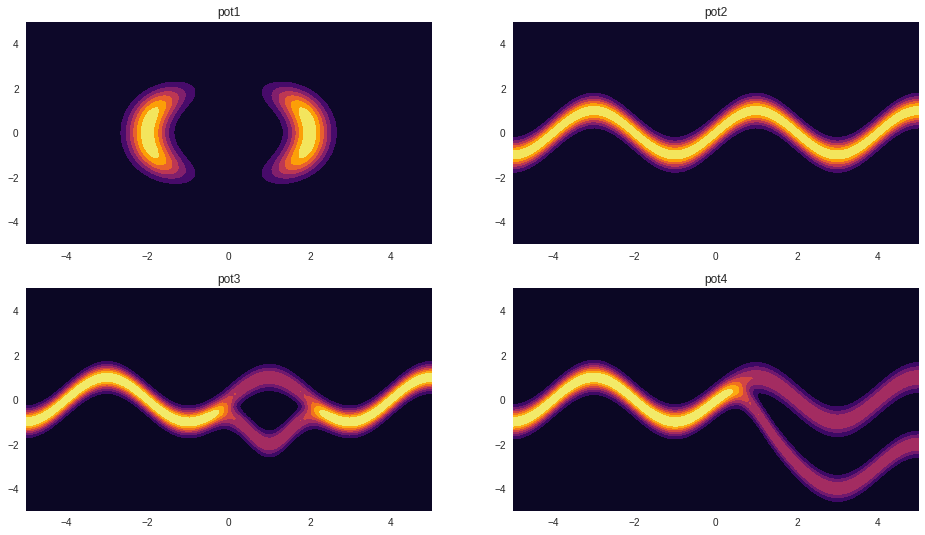

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))
ax = ax.flatten()
contour_pot(pot1f, ax[0], 'pot1');
contour_pot(pot2f, ax[1], 'pot2');
contour_pot(pot3f, ax[2], 'pot3');
contour_pot(pot4f, ax[3], 'pot4');

## Reprodusing first potential function

In [12]:
with pm.Model() as pot1m:
    pm.DensityDist('pot1', lambda x: -pot1(x), shape=(2,))

### NUTS
Let's use NUTS first. Just to have a look how good is it's approximation

In [13]:
with pot1m:
    trace = pm.sample(10000, init=None, start=dict(pot1=np.array([2, 0])))

Assigned NUTS to pot1
100%|██████████| 10500/10500 [00:17<00:00, 604.50it/s]


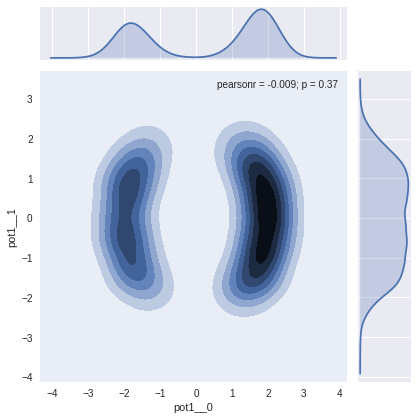

In [14]:
dftrace = pm.trace_to_dataframe(trace)
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')

### First try with flows

To make a first naive try with flows we do not need a lot of them. Let's use naive defaults with 2 planar flows and see what we'll get

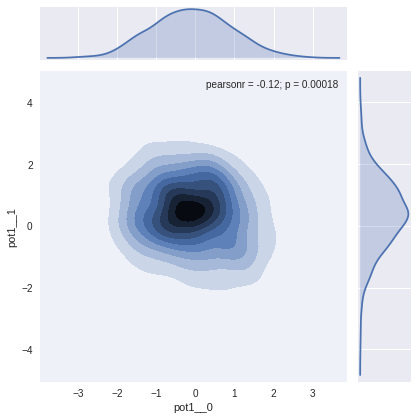

In [15]:
pm.set_tt_rng(2016)
np.random.seed(2016)
with pot1m:
    inference = pm.NFVI('planar*2', jitter=1)
## Plotting starting distribution
dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde');

#### Tracking gradients
It is not only interesting to track parameters but gradients too. In this setup different sampling points can give different gradients as single sampled point tends to collapse to a mode.

In [16]:
# here are params
inference.approx.params

[_u, _w, b, _u, _w, b]

In [17]:
# here is objective
inference.objective(nmc=None)

Elemwise{mul,no_inplace}.0

In [18]:
inference.objective(nmc=None).tag.test_value

AttributeError: 'scratchpad' object has no attribute 'test_value'

In [19]:
# here are gradients, as I do not compute test values for VI I need to change theano flag here
with theano.configparser.change_flags(compute_test_value='off'):
    grads = tt.grad(inference.objective(None), inference.approx.params)
grads

[Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0]

In [20]:
# all in
from collections import defaultdict
from itertools import count

@theano.configparser.change_flags(compute_test_value='off')
def get_tracker(inference):
    numbers = defaultdict(count)
    params = inference.approx.params
    grads = tt.grad(inference.objective(None), params)
    names = ['%s_%d' % (v.name, next(numbers[v.name])) for v in inference.approx.params]
    return pm.callbacks.Tracker(**dict(
      [(name, v.eval) for name, v in zip(names, params)] + [('grad_' + name, v.eval) for name, v in zip(names, grads)]
    ))
tracker = get_tracker(inference)

In [21]:
inference.fit(60000, obj_optimizer=pm.adam(learning_rate=0.01), callbacks=[tracker])

Average Loss = -1.3917: 100%|██████████| 60000/60000 [01:25<00:00, 702.07it/s] 
Finished [100%]: Average Loss = -1.4061


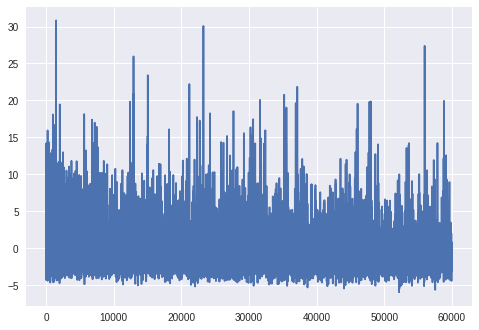

In [22]:
plt.plot(inference.hist);

Loss history is not very informative here. Tracker stats can be much more interesting

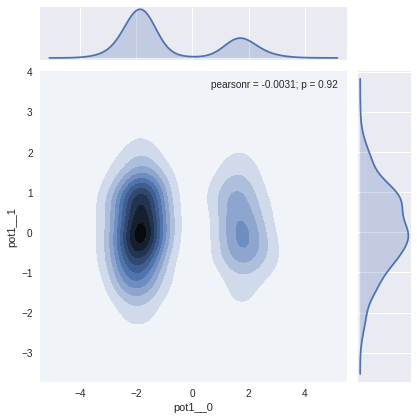

In [23]:
dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')

In [24]:
tracker.hist.keys()

dict_keys(['_u_0', '_w_0', 'b_0', '_u_1', '_w_1', 'b_1', 'grad__u_0', 'grad__w_0', 'grad_b_0', 'grad__u_1', 'grad__w_1', 'grad_b_1'])

In [25]:
from collections import Counter
def plot_tracker_results(tracker):
    fig, ax = plt.subplots(len(tracker.hist)//2, 2, figsize=(16, len(tracker.hist)//2*2.3))
    ax = ax.flatten()
    names = list(tracker.hist.keys())
    gnames = names[len(names)//2:]
    names = names[:len(names)//2]
    pairnames = zip(names, gnames)
    def plot_params_and_grads(name, gname):
        i = names.index(name)
        left = ax[i*2]
        right = ax[i*2+1]
        grads = np.asarray(tracker[gname])
        if grads.ndim == 1:
            grads = grads[:, None]
        grads = grads.T
        params = np.asarray(tracker[name])
        if params.ndim == 1:
            params = params[:, None]
        params = params.T
        right.set_title('Gradient of %s' % name)
        left.set_title('Param trace of %s' % name)
        s = params.shape[0]
        for j, (v, g) in enumerate(zip(params, grads)):
            left.plot(v, '-')
            right.plot(g, 'o', alpha=1/s/10)
        left.legend([name + '_%d' % j for j in range(len(names))])
        right.legend([gname + '_%d' % j for j in range(len(names))])

    for vn, gn in pairnames:
        plot_params_and_grads(vn, gn)
    fig.tight_layout()

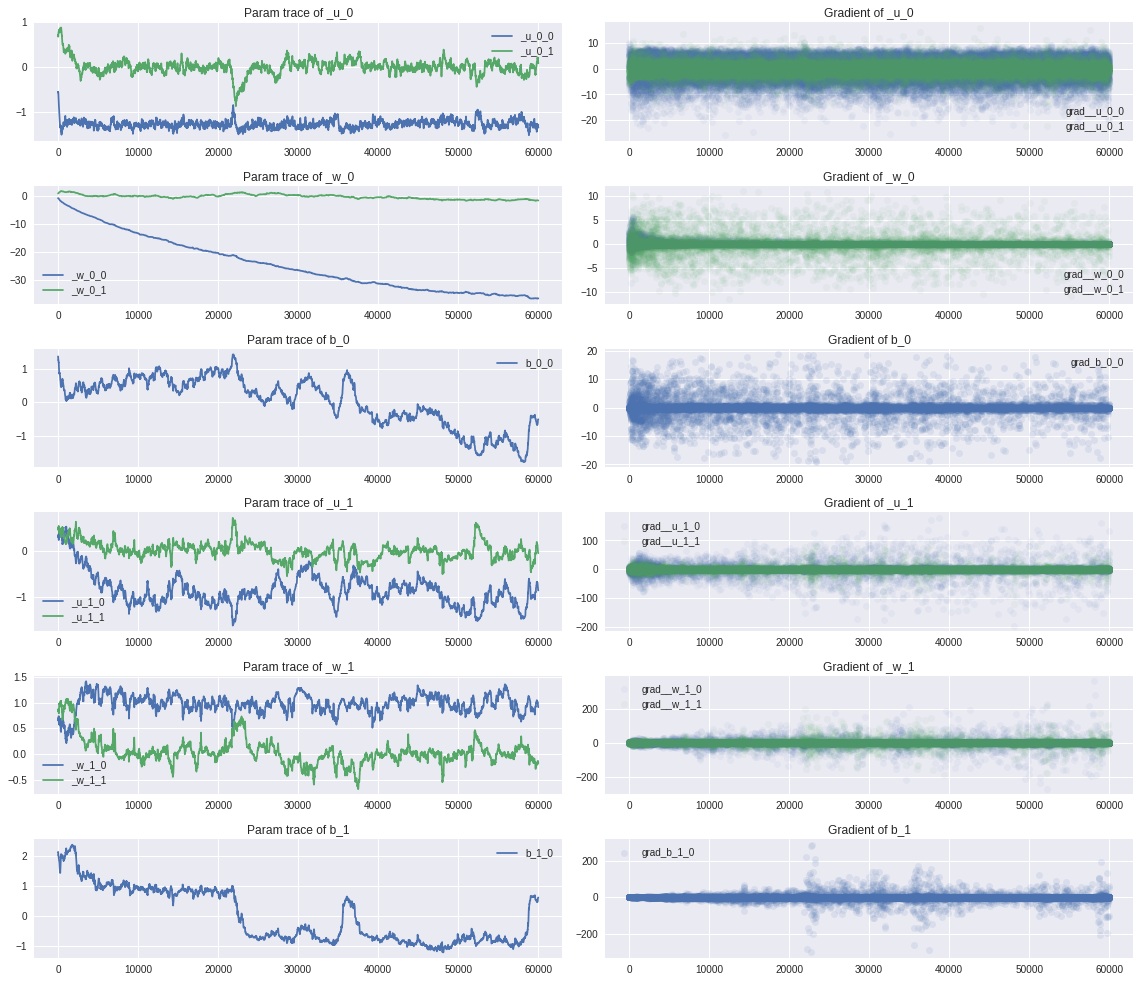

In [26]:
plot_tracker_results(tracker)

Seems like some parameters did not converge, I think we'd like to continue inference a bit more

In [27]:
inference.fit(60000, obj_optimizer=pm.adam(learning_rate=0.01), callbacks=[tracker])

Average Loss = -1.2703: 100%|██████████| 60000/60000 [01:17<00:00, 770.09it/s]
Finished [100%]: Average Loss = -1.2625


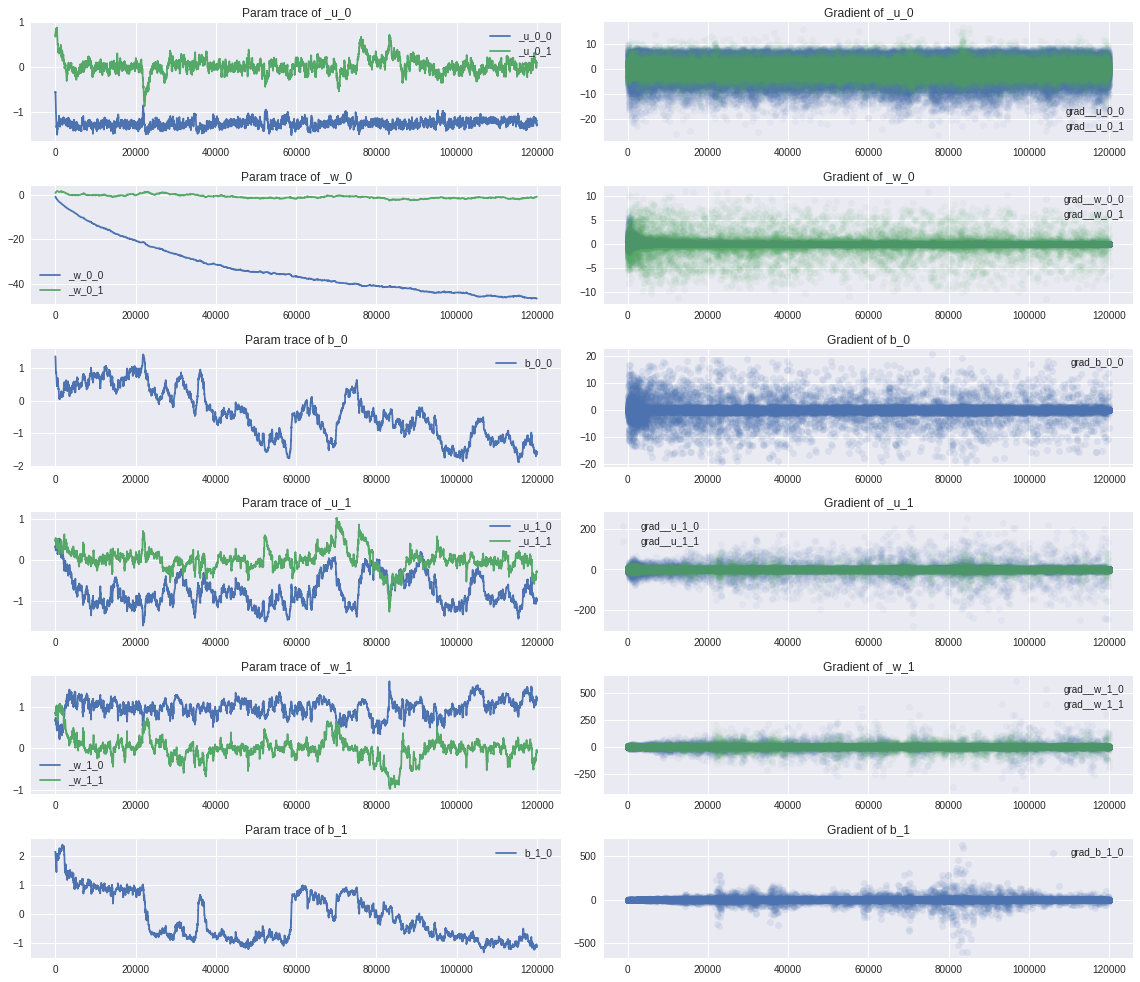

In [28]:
plot_tracker_results(tracker)

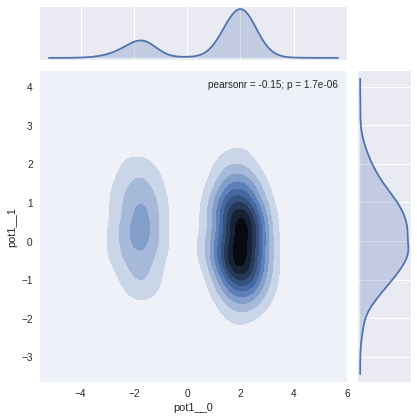

In [29]:
dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')

Inference is very unstable, variance of gradients is relativelly high to parameters. Dominant mode has changed. So be carefull in learning your flows

### Going deeper
We can try to improve our approximation using more flows, in paper they used 8 and 32, let's use 8 here.

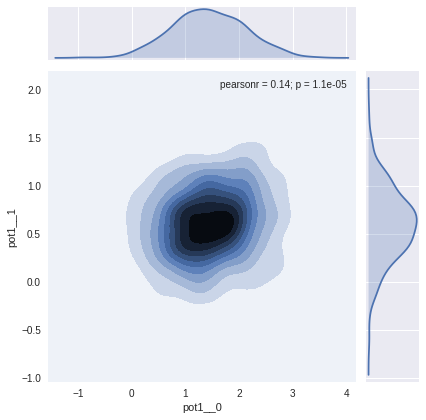

In [30]:
pm.set_tt_rng(2017)
np.random.seed(2017)
with pot1m:
    inference = pm.NFVI('planar*8', jitter=.5)
dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')

To get more robust fit can use more `obj_n_mc` in `fit`. But initial point still matters. I had to make careful choice about optimizer and `obj_n_mc` below

In [31]:
inference.fit(25000, obj_optimizer=pm.adam(learning_rate=0.01), obj_n_mc=100)

Average Loss = -1.76: 100%|██████████| 25000/25000 [02:21<00:00, 176.90it/s]  
Finished [100%]: Average Loss = -1.7604


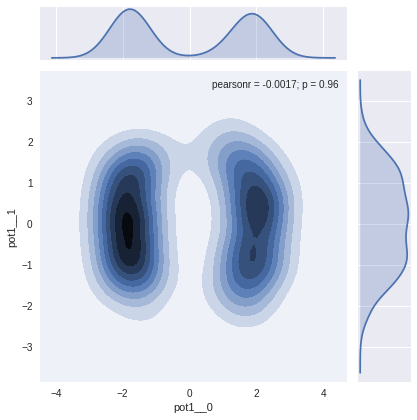

In [32]:
dftrace = pm.trace_to_dataframe(inference.approx.sample(1000))
sns.jointplot(dftrace.iloc[:, 0], dftrace.iloc[:, 1], kind='kde')

Nice one

Now we see that flows are able to catch multimodality structure of given posterior but in this case they are hard to fit as we have multimodal distribution. Initial point matters a lot in general multimodal case.